In [1]:
import sys
sys.path.append("../")

import numpy as np
from data.data_gen import simulation_run
from lib.nsindy import train_prune, train_ISTA, test
import lib.utils as utils
import random
from random import SystemRandom
import os

import torch
torch.set_default_dtype(torch.float64) 

/Users/klee263/venv-nsindy/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
save_path = 'experiments/'                                                                            
utils.makedirs(save_path)
experimentID = int(SystemRandom().random()*100000)                                                    
ckpt_path = os.path.join(save_path, "experiment_" + str(experimentID) + '.ckpt')                      
fig_save_path = os.path.join(save_path,"experiment_"+str(experimentID))                               
utils.makedirs(fig_save_path)
print(ckpt_path)  

experiments/experiment_36450.ckpt


In [3]:
T = 51.2
dt = 0.01
N_steps = int(np.floor(T/dt)) + 1
train_data, val_data, test_data, t = simulation_run("cubic", T, dt, 10, 10, 10)

generating training trials ...
generating validation trials ...
generating testing trials ...


In [4]:
from lib.odefunc import ODEfuncPoly
odefunc = ODEfuncPoly(2, 3)

## Train the NODE with L1 constraint (lasso) via proximal gradient

In [5]:
l1_reg = .1
train_ISTA(odefunc, 1e-2, 20, 100, 5, 10, "dopri5", train_data,t,l1_reg,ckpt_path,fig_save_path)

0 0.0002797043541791913
1 0.0003850248605492727
2 0.00027748741850075
3 0.00056320907354978
4 0.000586625896631568
5 0.0004460640688113624
6 0.000505393742492305
7 0.000557879572330653
8 0.0006330771248331854
9 0.00022189484651221697
10 0.0001457780317053262
11 0.00014738025365366794
12 8.276485397237854e-05
13 8.42462675546956e-05
14 1.3164968144006497e-05
15 4.566147716021616e-06
16 4.357394533604226e-06
17 1.4128953676812579e-06
18 2.3862943188909803e-06
19 3.8509235383972494e-06
Parameter containing:
tensor([[-0.0000e+00, -0.0000e+00,  0.0000e+00, -9.8005e-02,  0.0000e+00,
         -0.0000e+00,  1.2851e-05,  1.6979e-03, -4.6875e-04,  1.9958e+00],
        [-4.7080e-04, -0.0000e+00,  0.0000e+00, -1.9992e+00, -1.4788e-04,
          0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -9.8945e-02]],
       requires_grad=True)


test loss 0.01855711823903679


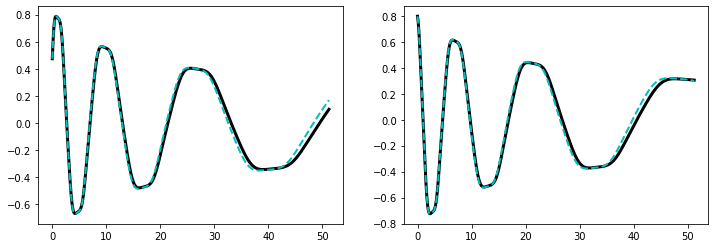

In [6]:
test(odefunc, "dopri5", test_data, t, ckpt_path, fig_save_path)

In [7]:
print(odefunc.C.weight)

Parameter containing:
tensor([[-0.0000e+00, -0.0000e+00,  0.0000e+00, -9.8005e-02,  0.0000e+00,
         -0.0000e+00,  1.2851e-05,  1.6979e-03, -4.6875e-04,  1.9958e+00],
        [-4.7080e-04, -0.0000e+00,  0.0000e+00, -1.9992e+00, -1.4788e-04,
          0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -9.8945e-02]],
       requires_grad=True)


## Train the NODE with adaptive lasso via proximal gradient

In [8]:
l1_reg *= 1 / (torch.abs(odefunc.C.weight.data)**(0.5) + 1e-4)
odefunc.C.reset_parameters()
train_ISTA(odefunc, 1e-2, 20, 100, 5, 10, "dopri5", train_data,t,l1_reg,ckpt_path,fig_save_path)

0 0.0014872624690669678
1 0.0013965522958399102
2 0.0005317544738477119
3 0.0006079641605691283
4 0.00031240641194047125
5 0.00030998616603148554
6 0.0001481690865746749
7 6.22860545835275e-05
8 7.69042395614942e-05
9 6.69510182399776e-05
10 2.666579311544963e-05
11 4.6228965535768083e-05
12 1.3868790373491869e-06
13 1.9593672039229255e-05
14 6.467578746597435e-06
15 1.0190322491457915e-05
16 8.666188940165096e-06
17 7.301623838695155e-06
18 3.193175958075091e-05
19 1.40318588804483e-05
Parameter containing:
tensor([[-0.0000, -0.0000,  0.0000, -0.0792, -0.0000,  0.0000, -0.0000,  0.0000,
          0.0000,  1.9990],
        [ 0.0000, -0.0000,  0.0000, -1.9986, -0.0000,  0.0000, -0.0000, -0.0000,
         -0.0000, -0.0851]], requires_grad=True)


test loss 0.20147855672926834


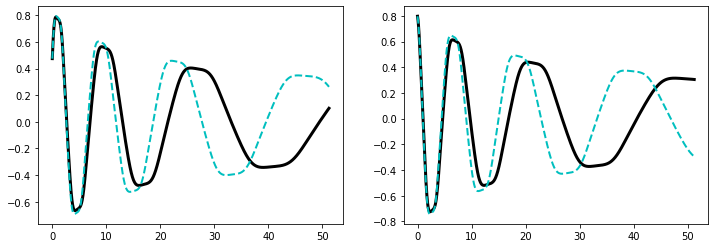

In [9]:
test(odefunc, "dopri5", test_data, t, ckpt_path, fig_save_path)

## Fine-tune the NODE via SGD with pruning 
(lower LR and longer batch sequence length)

In [11]:
train_prune(odefunc, 1e-3, 20, 100, 10, 10, "dopri5", train_data,val_data,t,ckpt_path,fig_save_path)

0 0.0004210300167351226
val loss 0.01770283722844153
saving... 0.01770283722844153
1 0.0004207993907344382
val loss 0.003286971426700633
saving... 0.003286971426700633
2 0.0004210389985524683
val loss 0.0017904570612859636
saving... 0.0017904570612859636
3 0.00042026660501857986
val loss 0.000904966831646296
saving... 0.000904966831646296
4 0.00042111051640307724
val loss 0.0014030166630095331
5 0.0004204465259489917
val loss 0.0007417775278679967
saving... 0.0007417775278679967
6 0.0004202357839907418
val loss 0.0005713018723088223
saving... 0.0005713018723088223
7 0.00042087164927913796
val loss 0.0009289003514326295
8 0.000420098099741891
val loss 0.0005857959239521942
9 0.00042009361382809856
val loss 0.0003932595553360687
saving... 0.0003932595553360687
10 0.00042029322675475
val loss 0.00017522772627762162
saving... 0.00017522772627762162
11 0.0004203923978563486
val loss 0.0012648891253341792
12 0.0004200822154574637
val loss 0.00044673551353476216
13 0.0004202628306246242
val l

<Figure size 432x288 with 0 Axes>

test loss 0.00016585227118222763


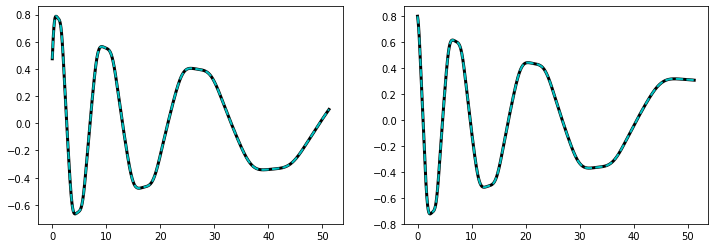

In [12]:
test(odefunc, "dopri5", test_data, t, ckpt_path, fig_save_path)

In [13]:
odefunc.get_dict()

$\dot{x_0}-0.09993698194889522x_0^3+2.0000009055408285x_1^3$
$\dot{x_1}-2.000074248293503x_0^3-0.10004149390947537x_1^3$
